In [82]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [83]:
path = '/kaggle/input/dataset/lfw'

In [84]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [85]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


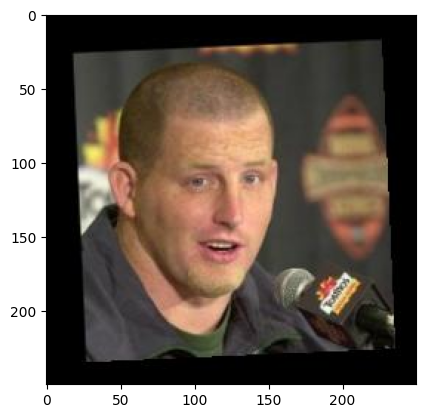

In [86]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

#### The differences between Autoencoders and Variational Autoencoders (VAEs) in terms of applications, architecture, and loss function:

##### Applications:
##### Autoencoders:

##### Data Compression: 
Autoencoders are often used for compressing and decompressing data. They learn a compressed representation of the input data.

##### Feature Learning: 
Autoencoders are good at learning meaningful features from data, which can be useful for tasks like image denoising and anomaly detection.
Variational Autoencoders (VAEs):

##### Generative Modeling: 
VAEs are particularly powerful for generative tasks. They can generate new samples from the learned distribution, making them suitable for image generation and synthesis.
Sample Generation: VAEs can be used to generate diverse and realistic samples in the latent space. This is especially beneficial for creative applications and image synthesis.

##### Architecture:
##### Autoencoders:

##### Deterministic Encoding: 
The encoder in autoencoders maps the input data to a fixed-size latent representation deterministically.

##### Latent Space: 
The latent space typically does not follow a specific distribution, and sampling from this space may not generate meaningful samples.

### Variational Autoencoders (VAEs):

##### Probabilistic Encoding: 
VAEs introduce a probabilistic approach in encoding. The encoder outputs both the mean and the log variance of a distribution in the latent space.
Stochastic Latent Space: VAEs sample from a distribution in the latent space using the reparameterization trick. This stochasticity allows for generating diverse samples during decoding.

##### Loss Function:
##### Autoencoders:

##### Reconstruction Loss: 
The primary loss is a reconstruction loss, often mean squared error (MSE) or a similar measure, which penalizes the difference between the input and the reconstructed output.

### Variational Autoencoders (VAEs):

##### Reconstruction Loss: 
VAEs also have a reconstruction loss, but it is complemented by an additional term, typically the Kullback-Leibler (KL) divergence.
##### KL Divergence: 
The KL divergence term regularizes the latent space, encouraging it to follow a specific distribution (usually a standard normal distribution). This regularization helps in generating diverse and meaningful samples during decoding.

In summary, while both Autoencoders and VAEs aim to learn efficient representations of data, VAEs, with their probabilistic approach and regularization through KL divergence, are especially well-suited for generative tasks and generating new samples in the latent space.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.enc_relu1 = nn.ReLU()
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.enc_relu2 = nn.ReLU()
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.enc_relu3 = nn.ReLU()

        # Latent space representation
        self.fc_mean = nn.Linear(128 * 32 * 32, 256)
        self.fc_logvar = nn.Linear(128 * 32 * 32, 256)

        # Decoder layers
        self.dec_fc = nn.Linear(256, 128 * 32 * 32)
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.dec_relu1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.dec_relu2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.dec_sigmoid = nn.Sigmoid()
        
        self.latent_dim = latent_dim

    def encoder(self, x):
        x = self.enc_conv1(x)
        x = self.enc_relu1(x)
        x = self.enc_bn1(x)
        x = self.enc_conv2(x)
        x = self.enc_relu2(x)
        x = self.enc_bn2(x)
        x = self.enc_conv3(x)
        x = self.enc_relu3(x)

        x = x.view(x.size(0), -1)  # Flatten
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)

        return mean, logvar

    def decoder(self, x):
        x = self.dec_fc(x)
        x = x.view(x.size(0), 128, 32, 32)
        x = self.dec_conv1(x)
        x = self.dec_relu1(x)
        x = self.dec_bn1(x)
        x = self.dec_conv2(x)
        x = self.dec_relu2(x)
        x = self.dec_bn2(x)
        x = self.dec_conv3(x)
        x = self.dec_sigmoid(x)

        return x

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean



## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [88]:
vae_model = VAE(latent_dim=256)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = vae_model.to(device)

data_iter = iter(dataloader)
images, _ = next(data_iter)
images = images.to(device)

sample_image = images[0].unsqueeze(0)  

with torch.no_grad():
    encoded_mean, encoded_logvar = vae_model.encoder(sample_image)
    sampled_latent = vae_model.reparameterize(encoded_mean, encoded_logvar)
    decoded_output = vae_model.decoder(sampled_latent)

    print("Shape of the encoder mean output:", encoded_mean.shape)
    print("Shape of the sampled latent space:", sampled_latent.shape)
    print("Shape of the decoder output:", decoded_output.shape)

    print("Shape of mu (mean of latent space):", encoded_mean.shape)
    print("Shape of logvar (log variance of latent space):", encoded_logvar.shape)


    with torch.no_grad():
        new_z = torch.randn_like(encoded_mean)
        new_samples = vae_model.decoder(new_z)

        print("Shape of generated samples in the latent space:", new_samples.shape)


Shape of the encoder mean output: torch.Size([1, 256])
Shape of the sampled latent space: torch.Size([1, 256])
Shape of the decoder output: torch.Size([1, 3, 32, 32])
Shape of mu (mean of latent space): torch.Size([1, 256])
Shape of logvar (log variance of latent space): torch.Size([1, 256])
Shape of generated samples in the latent space: torch.Size([1, 3, 32, 32])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [89]:
import torch.optim as optim

In [90]:
total_params_vae = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in VAE: {total_params_vae}")


Total number of trainable parameters in VAE: 100981635


In [91]:
learning_rate = 0.0001  
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

In [92]:
def vae_loss_function(recon_x, x, mu, logvar):

    reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    vae_loss = reconstruction_loss + beta * kl_loss

    return vae_loss


loss_function = vae_loss_function


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [101]:
from torch.nn.functional import interpolate

beta = 0.01
num_epochs = 100
for epoch in range(num_epochs):
    vae_model.train()
    total_loss = 0

    for data in dataloader:
        img, _ = data
        img = img.to(device)

        output, mu, logvar = vae_model(img)

        img_resized = interpolate(img, size=(output.size(2), output.size(3)), mode='bilinear', align_corners=False)

        loss = vae_loss_function(output, img_resized, mu, logvar)


        if torch.isnan(loss):
            print("NaN loss detected. Skipping update.")
            continue

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(vae_model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, average_loss))

Epoch [1/100], Loss: 21.4675
Epoch [2/100], Loss: 21.1001
Epoch [3/100], Loss: 20.7439
Epoch [4/100], Loss: 20.3862
Epoch [5/100], Loss: 20.0144
Epoch [6/100], Loss: 19.6995
Epoch [7/100], Loss: 19.4219
Epoch [8/100], Loss: 19.1152
Epoch [9/100], Loss: 18.7108
Epoch [10/100], Loss: 18.4696
Epoch [11/100], Loss: 18.1211
Epoch [12/100], Loss: 17.7843
Epoch [13/100], Loss: 17.6196
Epoch [14/100], Loss: 17.3004
Epoch [15/100], Loss: 17.1358
Epoch [16/100], Loss: 16.8673
Epoch [17/100], Loss: 16.6725
Epoch [18/100], Loss: 16.4438
Epoch [19/100], Loss: 16.2218
Epoch [20/100], Loss: 15.9799
Epoch [21/100], Loss: 15.8061
Epoch [22/100], Loss: 15.6153
Epoch [23/100], Loss: 15.5464
Epoch [24/100], Loss: 15.3153
Epoch [25/100], Loss: 15.0505
Epoch [26/100], Loss: 14.9285
Epoch [27/100], Loss: 14.8698
Epoch [28/100], Loss: 14.6115
Epoch [29/100], Loss: 14.4944
Epoch [30/100], Loss: 14.4045
Epoch [31/100], Loss: 14.2608
Epoch [32/100], Loss: 14.1323
Epoch [33/100], Loss: 14.0163
Epoch [34/100], Los

### Troubleshooting if Loss is Not Decreasing:

##### Learning Rate Adjustment:

If the loss is not decreasing, try adjusting the learning rate (lr) in the optimizer. You can experiment with different values, such as decreasing or increasing the learning rate.
##### Overfitting:

Check for signs of overfitting. If the model performs well on the training set but poorly on a separate validation set, it may be overfitting. Consider using a validation set to monitor generalization.
##### Data Issues:

Inspect the training data for any issues. Ensure that the data is preprocessed correctly and that there are no anomalies or inconsistencies.
##### Model Complexity:

Experiment with different model architectures or hyperparameters. The model may be too complex or too simple for the given task.
##### Regularization Techniques:

Introduce regularization techniques, such as dropout or weight decay, to prevent overfitting.
##### Gradient Clipping:

Implement gradient clipping to prevent exploding gradients, especially if using recurrent layers.
##### Debugging Loss Components:

Print and analyze individual components of the loss (reconstruction loss and KL divergence) to understand which part contributes more to the overall loss.
##### Monitoring Intermediate Outputs:

Monitor intermediate outputs, such as reconstructed images or latent space representations, to gain insights into what the model is learning.
##### Check for NaN Loss:

Ensure that the loss value is not becoming NaN during training. NaN losses indicate numerical instability and may require debugging.

## Step 7
Take a random image from the dataset and plot it together with new samples generated.



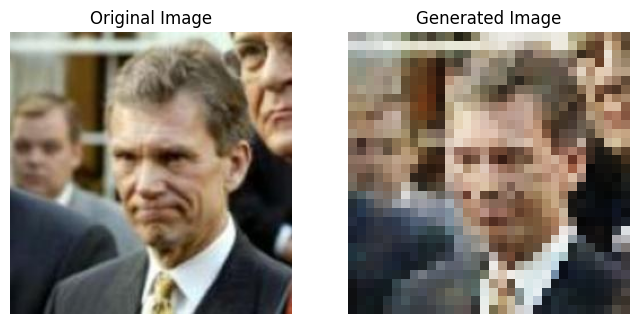

In [140]:
import matplotlib.pyplot as plt
import torch

vae_model.eval() 

images, _ = next(iter(dataloader))
original_image = images[0].unsqueeze(0).to(device)  

with torch.no_grad():
    mu, logvar = vae_model.encoder(original_image)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    generated_image = vae_model.decoder(z)

original_image_display = original_image.cpu().detach().numpy().squeeze().transpose(1, 2, 0)
generated_image_display = generated_image.cpu().detach().numpy().squeeze().transpose(1, 2, 0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image_display)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_image_display)
plt.title("Generated Image")
plt.axis('off')

plt.show()


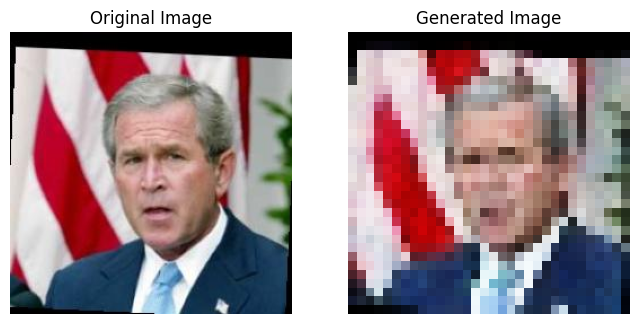

In [141]:
import matplotlib.pyplot as plt
import torch

vae_model.eval()  

images, _ = next(iter(dataloader))
original_image = images[0].unsqueeze(0).to(device) 

with torch.no_grad():
    mu, logvar = vae_model.encoder(original_image)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    generated_image = vae_model.decoder(z)

original_image_display = original_image.cpu().detach().numpy().squeeze().transpose(1, 2, 0)
generated_image_display = generated_image.cpu().detach().numpy().squeeze().transpose(1, 2, 0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image_display)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_image_display)
plt.title("Generated Image")
plt.axis('off')

plt.show()
